In [1]:
import numpy as npa
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import requests
from pandas.io.json import json_normalize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
CHD_LATITUDE = '30.7333'
CHD_LONGITUDE = '76.7794'
print('Coordinates of Chandigarh are {}, {}.'.format(CHD_LATITUDE, CHD_LONGITUDE))

Coordinates of Chandigarh are 30.7333, 76.7794.


In [6]:
import folium
chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)
folium.Marker([CHD_LATITUDE, CHD_LONGITUDE]).add_to(chandigarh_map)
chandigarh_map.save("C:/Users/S V ALEKHYA/Desktop/projects/Coursera_Capstone/Chandigarh Map.html")
chandigarh_map

## Foursquare Api

In [7]:
FOURSQUARE_CLIENT_ID = 'JESBJWR3P2HRAQPA4EBBGDULX1L3IUZV2AXO0ILYYCX3ITCG'
FOURSQUARE_CLIENT_SECRET = 'MX5ZL5B5K3G4WKUHAA3DEQ1QC5LWA2VAHCQEIDUFL0CPBF5N'
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100
VERSION = '27022020' # Current date

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Dataset01

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        CHD_LATITUDE, 
                                                                        CHD_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km
Total 17 venues fetched within a total radius of 4.0 Km

Total 117 venues fetched


## Dataset02

In [10]:
headers = {'user-key': 'b3a1c26ed20422bfaae7ada558744e1f'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

## Data cleaning

In [11]:
chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(chandigarh_map)  

chandigarh_map.save("C:/Users/S V ALEKHYA/Desktop/projects/Coursera_Capstone/Venues by Foursquare.html")
chandigarh_map

In [12]:
chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(chandigarh_map)  

chandigarh_map.save("C:/Users/S V ALEKHYA/Desktop/projects/Coursera_Capstone/Venues by Zomato.html")
chandigarh_map

In [13]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [14]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [15]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,The Coffee Bean & Tea Leaf,Coffee Shop,30.7297,76.7732,Starbucks Coffee,30.7299,76.7732,500.0,2.0,3.8,"Sector 22 C, Near Sector 22, Chandigarh",0.0002,0.0000
1,Softy Corner,Ice Cream Shop,30.7404,76.7816,Softy Corner,30.7405,76.7816,400.0,1.0,4.5,"SCO 87, Sector 17, Chandigarh",0.0001,0.0000
2,Sector 17,Miscellaneous Shop,30.7395,76.7822,Hot Stoppers,30.7399,76.7818,300.0,1.0,3.1,"SCO 68 & 69, Sector 17 C, Near Sector 17, Chan...",0.0004,-0.0004
3,Aroma 22,Hotel Bar,30.7301,76.7736,McDonald's,30.7302,76.7737,500.0,2.0,4.1,"Hotel Aroma Complex, Himalaya Marg, Sector 22 ...",0.0001,0.0001
4,Backpackers Cafe,Sandwich Place,30.7477,76.7933,Nik Baker's,30.7479,76.7933,900.0,2.0,4.1,"Booth 31-34, Inner Market, Sector 9 D, Near Se...",0.0002,0.0000
5,Barbeque Nation,BBQ Joint,30.7256,76.8052,UBQ by Barbeque Nation,30.7257,76.8052,500.0,2.0,3.6,"SCO 39, Madhya Marg, Sector 26, Chandigarh",0.0001,0.0000
6,Indian Coffee House,Coffee Shop,30.7403,76.7809,The Crown Patisserie Cafe,30.7402,76.7809,1100.0,3.0,4.3,"SCO 14, 1st Floor, Sector 17 E, Sector 17, Cha...",-0.0001,0.0000
7,Nik Bakers,Bakery,30.7214,76.7602,Nik Baker's,30.7216,76.7601,900.0,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",0.0002,-0.0001
8,Hot Millions 2,Fast Food Restaurant,30.7406,76.7825,Hot Millions,30.7408,76.7823,800.0,2.0,2.2,"SCO 73, 74, Sector 17 D, Near Sector 17, Chand...",0.0002,-0.0002
9,Mainland China,Chinese Restaurant,30.7255,76.8052,Mainland China,30.7256,76.8053,1500.0,3.0,4.1,"SCO 40, Madhya Marg, Sector 26, Chandigarh",0.0001,0.0001


In [17]:
selected_venues = selected_venues.drop([0, 20, 25, 29, 32, 34, 47, 49, 56, 57, 58, 59, 60]).reset_index(drop = True)

In [18]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [19]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 49


## Analysis

<BarContainer object of 29 artists>

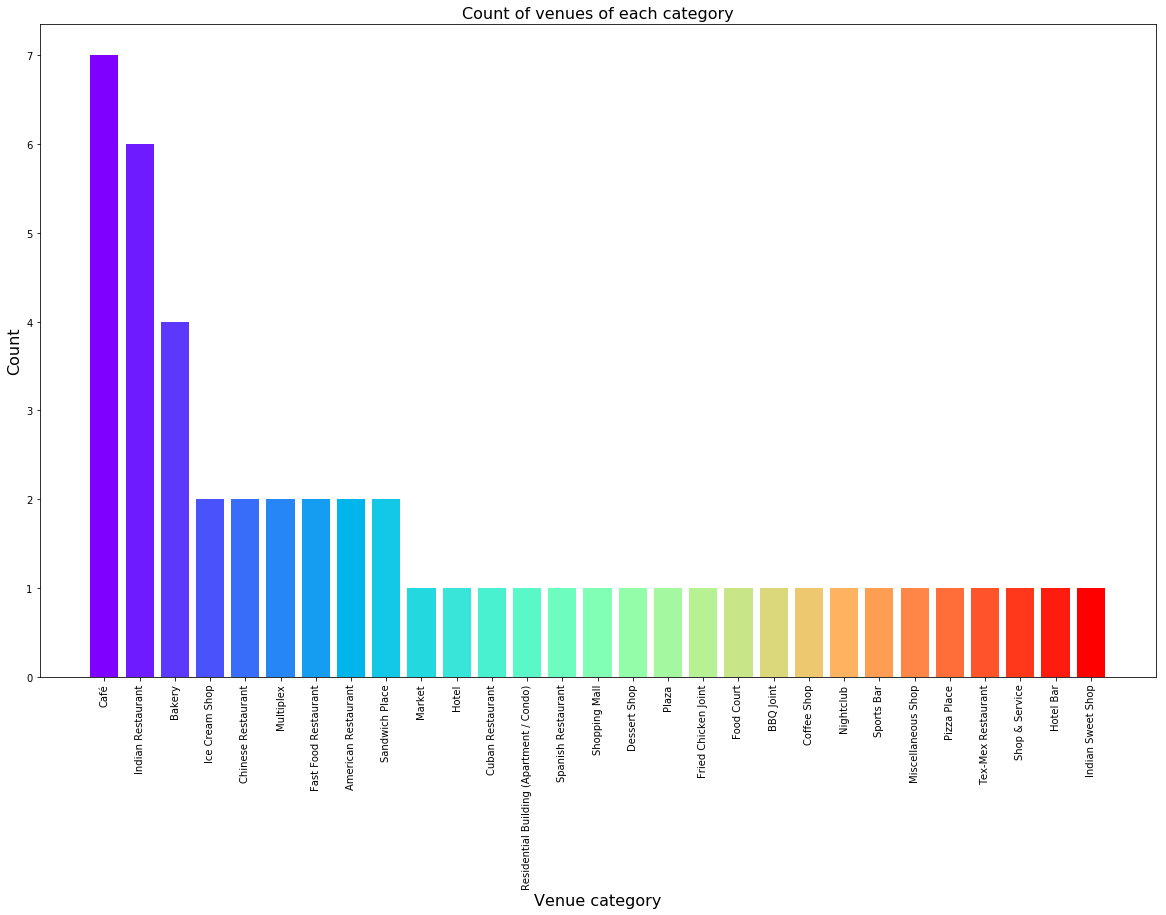

In [20]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

Text(0.5, 1.0, 'Count of venues with given rating')

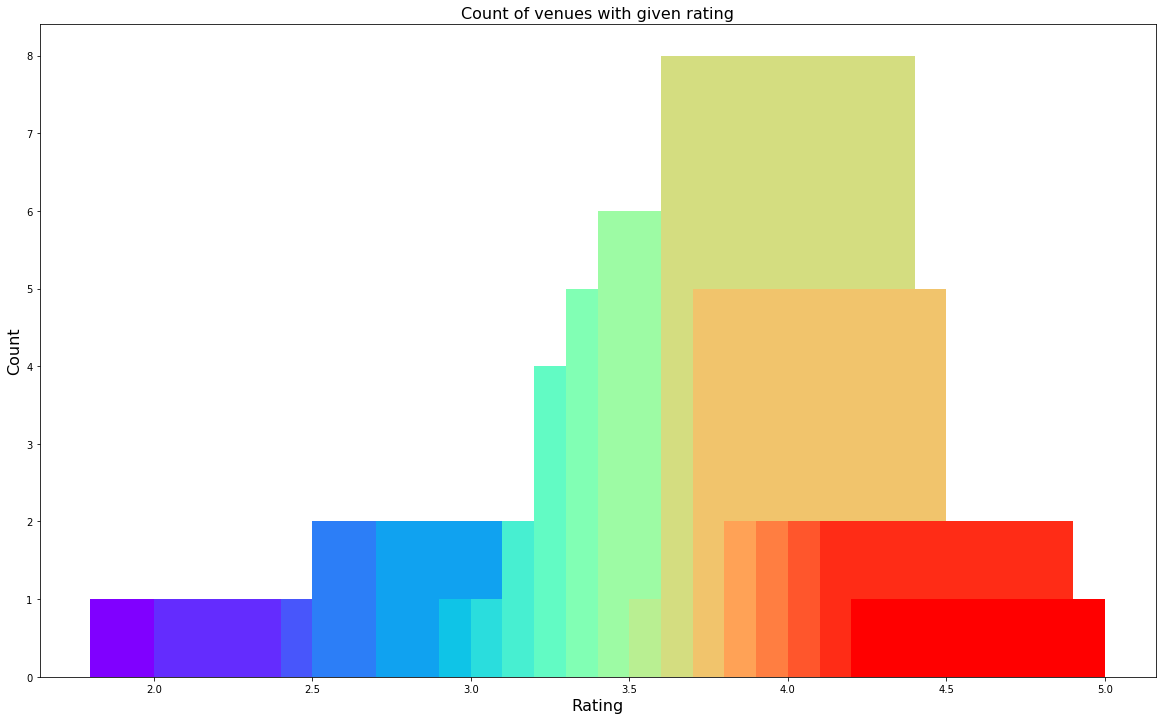

In [21]:
#Rating
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

In [22]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

In [24]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(chandigarh_map)  

chandigarh_map.save("C:/Users/S V ALEKHYA/Desktop/projects/Coursera_Capstone/Venues Ratings.html")
chandigarh_map

Text(0.5, 1.0, 'Count of venues with given average price')

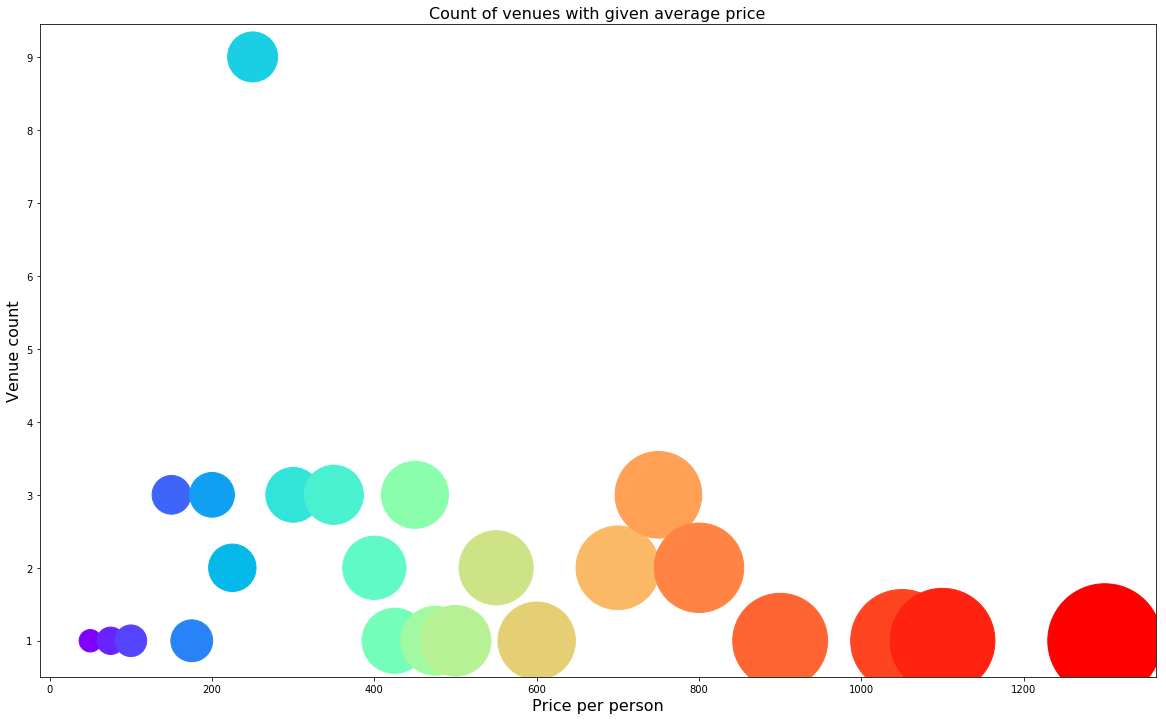

In [25]:
#Price
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

In [27]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(chandigarh_map)  

chandigarh_map.save("C:/Users/S V ALEKHYA/Desktop/projects/Coursera_Capstone/Venues Prices.html")
chandigarh_map

## Clustering

In [ ]:
from sklearn.cluster import KMeans
NO_OF_CLUSTERS = 2
clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)

In [31]:
selected_venues.head()

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Ice Cream Shop,Softy Corner,30.7405,76.7816,1.0,4.5,"SCO 87, Sector 17, Chandigarh",200.0,Very good
1,0,Miscellaneous Shop,Hot Stoppers,30.7399,76.7818,1.0,3.1,"SCO 68 & 69, Sector 17 C, Near Sector 17, Chan...",150.0,Good
2,0,Hotel Bar,McDonald's,30.7302,76.7737,2.0,4.1,"Hotel Aroma Complex, Himalaya Marg, Sector 22 ...",250.0,Very good
3,0,Sandwich Place,Nik Baker's,30.7479,76.7933,2.0,4.1,"Booth 31-34, Inner Market, Sector 9 D, Near Se...",450.0,Very good
4,0,BBQ Joint,UBQ by Barbeque Nation,30.7257,76.8052,2.0,3.6,"SCO 39, Madhya Marg, Sector 26, Chandigarh",250.0,Good


In [32]:
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(chandigarh_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(chandigarh_map)

chandigarh_map.save("C:/Users/S V ALEKHYA/Desktop/projects/Coursera_Capstone/Venues Clusters.html")
chandigarh_map

In [33]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Ice Cream Shop,Softy Corner,30.7405,76.7816,1.0,4.5,"SCO 87, Sector 17, Chandigarh",200.0,Very good
1,0,Miscellaneous Shop,Hot Stoppers,30.7399,76.7818,1.0,3.1,"SCO 68 & 69, Sector 17 C, Near Sector 17, Chan...",150.0,Good
2,0,Hotel Bar,McDonald's,30.7302,76.7737,2.0,4.1,"Hotel Aroma Complex, Himalaya Marg, Sector 22 ...",250.0,Very good
3,0,Sandwich Place,Nik Baker's,30.7479,76.7933,2.0,4.1,"Booth 31-34, Inner Market, Sector 9 D, Near Se...",450.0,Very good
4,0,BBQ Joint,UBQ by Barbeque Nation,30.7257,76.8052,2.0,3.6,"SCO 39, Madhya Marg, Sector 26, Chandigarh",250.0,Good
5,0,Coffee Shop,The Crown Patisserie Cafe,30.7402,76.7809,3.0,4.3,"SCO 14, 1st Floor, Sector 17 E, Sector 17, Cha...",550.0,Very good
6,0,Bakery,Nik Baker's,30.7216,76.7601,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",450.0,Very good
7,0,Fast Food Restaurant,Hot Millions,30.7408,76.7823,2.0,2.2,"SCO 73, 74, Sector 17 D, Near Sector 17, Chand...",400.0,Okay
8,0,Bakery,Nik Baker's,30.7479,76.7933,2.0,4.1,"Booth 31-34, Inner Market, Sector 9 D, Near Se...",450.0,Very good
9,0,Indian Restaurant,Old Pal Dhaba,30.7193,76.8016,2.0,2.8,"Booth 165-166, Sector 28 D, Near Sector 28, Ch...",400.0,Okay


In [34]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.76 and rating spread around 3.68


In [35]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Chinese Restaurant,Mainland China,30.7256,76.8053,3.0,4.1,"SCO 40, Madhya Marg, Sector 26, Chandigarh",750.0,Very good
1,1,Café,Cafe Nomad,30.7330,76.8033,3.0,4.0,"178, Inner Market, Sector 7, Chandigarh",750.0,Good
2,1,Spanish Restaurant,Casa Bella Vista Pizzeria,30.7547,76.7872,3.0,4.1,"Coal Depot, Backide Market, Sector 10 D, Near ...",700.0,Very good
3,1,Cuban Restaurant,Virgin Courtyard,30.7348,76.7977,4.0,4.4,"SCO 1A, Behind Madhya Marg, Sector 7C, Near Se...",1100.0,Very good
4,1,Chinese Restaurant,The Great Kabab Factory,30.7253,76.8058,3.0,4.0,"SCO 43, Madhya Marg, Sector 26, Chandigarh",800.0,Good
5,1,Multiplex,Pyro,30.7235,76.7677,3.0,3.8,"Ground Floor, Piccadilly Square Mall, Block A,...",800.0,Good
6,1,American Restaurant,Peddlers,30.7208,76.7592,3.0,3.8,"Hotel Heritage, SCO 467 & 468, Sector 35 C, Se...",700.0,Good
7,1,Sports Bar,The Brew Estate,30.7057,76.8006,4.0,4.4,"308, 3rd Floor, Elante Mall, Phase 1, Chandiga...",1050.0,Very good
8,1,Café,Backpackers Cafe,30.7049,76.8011,3.0,4.2,"48 A, Courtyard, Elante Mall, Phase 1, Chandig...",600.0,Very good
9,1,Nightclub,Kings Cross - The Altius Boutique Hotel,30.7006,76.7920,4.0,3.5,"The Altius Hotel, 25/9, Phase 2, Chandigarh In...",1300.0,Good
